In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [269]:
from os import listdir
from os.path import join, isfile, splitext, basename
from pathlib import Path
import pandas as pd
import torch
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import numpy as np
from skimage import io, transform

import matplotlib.pyplot as plt

class PaperDataset(data.Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform

        image_folder_path = join(self.dataset_path, "image")
#         image_folder_path = list(filter(lambda x: basename(x) == ".png", image_folder_path))
        df_path = join(dataset_path, 'label.csv') 

        self.df = df = pd.read_csv(df_path, dtype={'paper_id':"string", 'accepted':bool})
        
        def get_full_file_path(folder_path):
            return sorted([join(folder_path, x) for x in listdir(folder_path)])
        image_full_file_path = get_full_file_path(image_folder_path)
        image_full_file_path = list(filter(lambda x: Path(x).suffix == '.png', image_full_file_path))
        
        
        all_id = list(filter(lambda x: Path(x).suffix == '.png', listdir(image_folder_path)))
        self.all_id = all_id = [x[:-4] for x in all_id]
        
#         print(all_id)
#         print(df['paper_id'])
#         print("orignal lenght", len(df))
        mask = df['paper_id'].isin(all_id)
        self.df = df = df.loc[mask]
#         print(df)

        self.image_path = sorted(image_full_file_path)

        print(len(self.image_path), len(df))
        assert(len(self.image_path) == len(df))

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, idx):
        this_img_path = self.image_path[idx]
        image = io.imread(this_img_path) / 255.

        def get_file_name(path):
            return splitext(basename(path))[0]

        paper_id = get_file_name(this_img_path)
        df = self.df
        label = (bool(df[df.paper_id == paper_id].accepted.item()) == True) 
#         label = (bool(df[df.paper_id == int(paper_id)].accepted.item()) == True) 
        label = 1 if label else 0

        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def show_ratio(self):
        print(self.df['accepted'].value_counts())
    
    def get_label(self):
        return list(self.df['accepted'])


# mean = [0.9449, 0.9453, 0.9448]
# std = [0.0761, 0.0752, 0.0765]
mean, std = [0.9451, 0.9457, 0.9450], [0.0775, 0.0765, 0.0780]
normalize = torchvision.transforms.Normalize(mean=mean, std=std)

preprocessing = transforms.Compose([transforms.ToTensor(),
                                    transforms.ConvertImageDtype(torch.float),
                                    transforms.Resize(224),
                                    normalize,
                                    ])

train_set = PaperDataset('./data/arxiv.cs.lg_2007-2017/train', transform=preprocessing)
# n_total = len(train_set)
# n_val = int(n_total * 0.1)
# n_train = n_total - n_val
# train_set, val_set = torch.utils.data.random_split(non_test_set, [n_train, n_val])

batch_size = 32
n_worker = 4
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, num_workers=n_worker,
    shuffle=True, pin_memory=True)

def compute_mean_std(loader):
    mean, std = 0., 0.
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    return mean, std
# print("mean, std:", compute_mean_std(train_loader))

test_set = PaperDataset('./data/arxiv.cs.lg_2007-2017/test', transform=preprocessing)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=25, num_workers=n_worker,
    shuffle=False, pin_memory=True, drop_last=False)
dataloaders = {'train': train_loader, 'test': test_loader}

def get_baseline(dataset):
    labels = np.array(dataset.get_label())
    a = (labels == 0).sum()
    b = (labels == 1).sum()
    return max(a, b)/(a+b)

print("train_set and test_set number:")
train_set.show_ratio()
test_set.show_ratio()
train_baseline = get_baseline(train_set)
test_baseline = get_baseline(test_set)
print("baseline ratio for train:", train_baseline)
print("baseline ratio for test:", test_baseline)
# non_test_ratio = get_baseline(non_test_set)
# test_ratio = get_baseline(test_set)
# print("get_baseline(non_test_set), get_baseline(test_set):", non_test_ratio, test_ratio)
# print("len(train_set), len(val_set), len(test_set):", len(train_set), len(val_set), len(test_set))

orignal lenght 4543
4483 4483
orignal lenght 253
250 250
train_set and test_set number:
False    2837
True     1646
Name: accepted, dtype: int64
False    170
True      80
Name: accepted, dtype: int64
baseline ratio for train: 0.6328351550301138
baseline ratio for test: 0.68


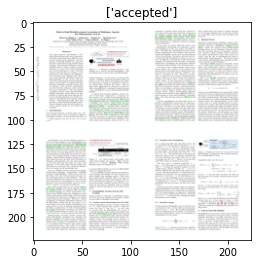

In [270]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ["rejected", "accepted"]
imshow(inputs[0], title=[class_names[classes[0]]])
# imshow(out, title=[class_names[x] for x in classes])

In [271]:
import time, copy
from tqdm import tqdm

import torch.nn as nn
import torch.nn.functional as F

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_history = {'train': [], 'test': []}
    acc_history = {'train': [], 'test': []}
    for epoch in range(num_epochs):
        dataset_sizes = {'train': len(train_set), 'test': len(test_set)}
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        if epoch == num_epochs - 1:
            phases = ['test', 'train', 'test']
        else:
            phases = ['test', 'train']
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            loss_history[phase].append(epoch_loss)
            acc_history[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history, acc_history, best_acc

In [273]:
"Training ResNet"

import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Sequential(
#     nn.Dropout(0.3),
    nn.Linear(num_ftrs, 2),
)

layers = nn.Sequential(*list(model_ft.children())[:-3])
for param in layers.parameters():
    param.requires_grad = False

model_ft = model_ft.to(device)

labels = torch.tensor(train_set.get_label())
loss_weight = 1./(torch.tensor([(labels == 0).sum(), (labels == 1).sum()]
                               ).to(device).float() + 1e-32)
print("loss_weight", loss_weight)

criterion = nn.CrossEntropyLoss(weight=loss_weight)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

resnet_tuned, loss_history, acc_history, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, 
                                                      num_epochs=20)
# torch.save(resnet_tuned.state_dict(), f"./resnet_tuned_{best_acc}.pth")
torch.save(resnet_tuned, f"./resnet_tuned_{best_acc}.pth")

Using cache found in /home/lucien/.cache/torch/hub/pytorch_vision_v0.10.0


loss_weight tensor([0.0004, 0.0006], device='cuda:0')
Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.58it/s]


test Loss: 0.9078 Acc: 0.3200


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:05<00:00, 27.66it/s]


train Loss: 0.5564 Acc: 0.7160

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.84it/s]


test Loss: 0.4380 Acc: 0.7800


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 28.80it/s]


train Loss: 0.4434 Acc: 0.7856

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.75it/s]


test Loss: 0.4923 Acc: 0.7560


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:05<00:00, 27.99it/s]


train Loss: 0.3671 Acc: 0.8314

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.94it/s]


test Loss: 0.4155 Acc: 0.8200


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 28.21it/s]


train Loss: 0.2616 Acc: 0.8905

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.66it/s]


test Loss: 0.4678 Acc: 0.8040


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 29.10it/s]


train Loss: 0.1805 Acc: 0.9311

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.25it/s]


test Loss: 0.4857 Acc: 0.8040


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 28.24it/s]


train Loss: 0.1247 Acc: 0.9525

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.07it/s]


test Loss: 0.5230 Acc: 0.8120


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 28.58it/s]


train Loss: 0.0683 Acc: 0.9835

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.60it/s]


test Loss: 0.6161 Acc: 0.8120


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 28.21it/s]


train Loss: 0.0595 Acc: 0.9844

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.71it/s]


test Loss: 0.6058 Acc: 0.8160


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 28.78it/s]


train Loss: 0.0360 Acc: 0.9906

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12it/s]


test Loss: 0.6871 Acc: 0.8320


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 28.44it/s]


train Loss: 0.0188 Acc: 0.9973

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.63it/s]


test Loss: 0.6828 Acc: 0.8080


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 28.80it/s]


train Loss: 0.0159 Acc: 0.9975

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.72it/s]


test Loss: 0.6699 Acc: 0.8040


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 28.79it/s]


train Loss: 0.0118 Acc: 0.9993

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.01it/s]


test Loss: 0.6678 Acc: 0.8160


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:05<00:00, 27.79it/s]


train Loss: 0.0134 Acc: 0.9971

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.31it/s]


test Loss: 0.6979 Acc: 0.8160


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 28.57it/s]


train Loss: 0.0091 Acc: 0.9993

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.45it/s]


test Loss: 0.6941 Acc: 0.7960


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 28.75it/s]


train Loss: 0.0124 Acc: 0.9987

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.84it/s]


test Loss: 0.7217 Acc: 0.8240


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 28.52it/s]


train Loss: 0.0103 Acc: 0.9996

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.78it/s]


test Loss: 0.6986 Acc: 0.8200


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:05<00:00, 28.18it/s]


train Loss: 0.0117 Acc: 0.9993

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.73it/s]


test Loss: 0.6979 Acc: 0.8040


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 28.30it/s]


train Loss: 0.0100 Acc: 0.9991

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.35it/s]


test Loss: 0.7097 Acc: 0.8120


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 29.04it/s]


train Loss: 0.0114 Acc: 0.9984

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.13it/s]


test Loss: 0.6744 Acc: 0.8200


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:04<00:00, 28.77it/s]


train Loss: 0.0083 Acc: 0.9998


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.72it/s]


test Loss: 0.6807 Acc: 0.8160

Training complete in 1m 56s
Best test Acc: 0.832000


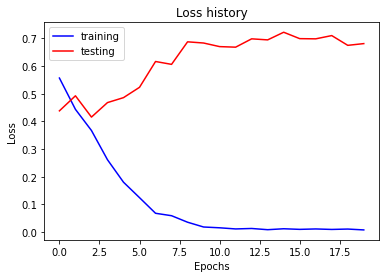

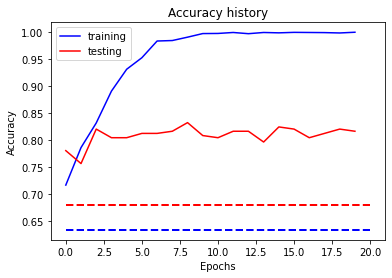

In [274]:
"Plot acc for ResNet"

def to_cpu(lst):
    if type(lst[0]) == float:
        return lst
    else:
        return [x.cpu() for x in lst]
    
def plot_history(name, train_history, test_history):
    plt.figure()
    test_history = test_history[1:]

    plt.plot(range(len(train_history)), to_cpu(train_history), "-b", label="training")
    plt.plot(range(len(test_history)), to_cpu(test_history), "-r", label="testing")
    if name == 'Accuracy':
        plt.plot([0, len(train_history)], [train_baseline, train_baseline], '--b', lw=2)
        plt.plot([0, len(train_history)], [test_baseline, test_baseline], '--r', lw=2)
    plt.title(f"{name} history")
    plt.legend()
    plt.ylabel(name)
    plt.xlabel("Epochs")
    plt.show()

plot_history("Loss", loss_history['train'], loss_history['test'])
plot_history("Accuracy", acc_history['train'], acc_history['test'])

orignal lenght 253
250 250


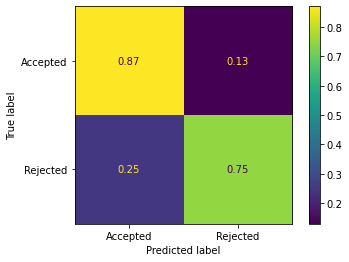

In [279]:
"Confusion Matrix for Resnet"

from sklearn.metrics import ConfusionMatrixDisplay

def to_np(x):
    return x.cpu().detach().numpy()

def give_confusion_display(model, dataset, n_class=2, is_cuda=False, is_normalized=True):
    device = "cuda:0" if is_cuda else "cpu"
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    model.eval()

    dataloader_args = {"num_workers": 1, "pin_memory": False} if is_cuda else {}
    loader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=False, **dataloader_args)

    cm = torch.zeros(n_class, n_class)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    cm[t.long(), p.long()] += 1

    showing_cm = cm = to_np(cm)
    normalized_cm = cm / cm.sum(axis=1).reshape((-1, 1))
    if is_normalized:
        showing_cm = normalized_cm
    disp = ConfusionMatrixDisplay(confusion_matrix=showing_cm, 
                              display_labels=["Accepted", "Rejected"])
    return disp

# model = torch.load(f"./resnet_tuned_0.748.pth")
model = resnet_tuned
dataset = PaperDataset('./data/arxiv.cs.lg_2007-2017/test', transform=preprocessing)
disp = give_confusion_display(model, dataset)
disp.plot()
plt.show()

In [276]:
"Training VGG"

import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11_bn', pretrained=True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, 2)

layers = nn.Sequential(*list(model_ft.children())[-1])
for param in layers.parameters():
    param.requires_grad = False

model_ft = model_ft.to(device)

labels = torch.tensor(train_set.get_label())
loss_weight = 1./(torch.tensor([(labels == 0).sum(), (labels == 1).sum()]
                               ).to(device).float() + 1e-32)
print("loss_weight", loss_weight)

criterion = nn.CrossEntropyLoss(weight=loss_weight)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

vgg_tuned, vgg_loss_history, vgg_acc_history, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, 
                                                           num_epochs=20)
torch.save(vgg_tuned, f'./vgg_tuned_{best_acc}.pth')

Using cache found in /home/lucien/.cache/torch/hub/pytorch_vision_v0.10.0


loss_weight tensor([0.0004, 0.0006], device='cuda:0')
Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.71it/s]


test Loss: 0.6985 Acc: 0.5720


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.88it/s]


train Loss: 0.6484 Acc: 0.6112

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00, 10.00it/s]


test Loss: 0.5738 Acc: 0.6840


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.84it/s]


train Loss: 0.5383 Acc: 0.7357

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.58it/s]


test Loss: 0.4951 Acc: 0.7400


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.85it/s]


train Loss: 0.4723 Acc: 0.7781

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.49it/s]


test Loss: 0.4471 Acc: 0.7720


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.85it/s]


train Loss: 0.4386 Acc: 0.7983

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.91it/s]


test Loss: 0.4312 Acc: 0.7680


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.85it/s]


train Loss: 0.4167 Acc: 0.8082

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.97it/s]


test Loss: 0.4190 Acc: 0.7920


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.85it/s]


train Loss: 0.3885 Acc: 0.8249

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.95it/s]


test Loss: 0.4286 Acc: 0.7720


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.84it/s]


train Loss: 0.3584 Acc: 0.8418

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.16it/s]


test Loss: 0.4003 Acc: 0.7960


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.85it/s]


train Loss: 0.3268 Acc: 0.8584

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.77it/s]


test Loss: 0.4131 Acc: 0.7800


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.83it/s]


train Loss: 0.3069 Acc: 0.8746

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.59it/s]


test Loss: 0.3978 Acc: 0.8040


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.82it/s]


train Loss: 0.2683 Acc: 0.8898

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.86it/s]


test Loss: 0.4115 Acc: 0.7960


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.84it/s]


train Loss: 0.2206 Acc: 0.9266

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.81it/s]


test Loss: 0.3984 Acc: 0.8040


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.85it/s]


train Loss: 0.2108 Acc: 0.9286

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.50it/s]


test Loss: 0.4074 Acc: 0.8120


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.84it/s]


train Loss: 0.1997 Acc: 0.9329

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.08it/s]


test Loss: 0.4075 Acc: 0.8040


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.84it/s]


train Loss: 0.2021 Acc: 0.9335

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.04it/s]


test Loss: 0.4138 Acc: 0.7920


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.85it/s]


train Loss: 0.1917 Acc: 0.9364

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.08it/s]


test Loss: 0.3964 Acc: 0.8080


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.85it/s]


train Loss: 0.1878 Acc: 0.9407

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.05it/s]


test Loss: 0.4007 Acc: 0.8080


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.83it/s]


train Loss: 0.1789 Acc: 0.9471

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.88it/s]


test Loss: 0.4088 Acc: 0.7960


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.85it/s]


train Loss: 0.1780 Acc: 0.9451

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.55it/s]


test Loss: 0.4051 Acc: 0.8080


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.83it/s]


train Loss: 0.1654 Acc: 0.9520

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.16it/s]


test Loss: 0.4112 Acc: 0.7960


100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.84it/s]


train Loss: 0.1667 Acc: 0.9538


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.03it/s]


test Loss: 0.4201 Acc: 0.7920

Training complete in 7m 14s
Best test Acc: 0.812000


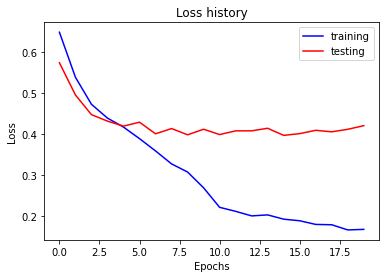

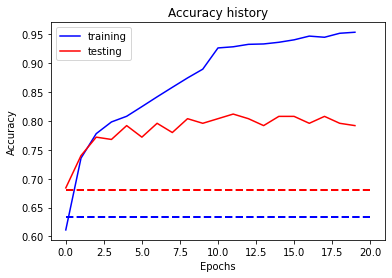

In [277]:
"Plot acc for vgg"

plot_history("Loss", vgg_loss_history['train'], vgg_loss_history['test'])
plot_history("Accuracy", vgg_acc_history['train'], vgg_acc_history['test'])

orignal lenght 253
250 250


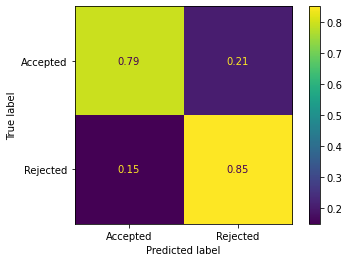

In [278]:
"Confusion Matrix for VGG"

model = vgg_tuned
dataset = PaperDataset('./data/arxiv.cs.lg_2007-2017/test', transform=preprocessing)
disp = give_confusion_display(model, dataset)
disp.plot()
plt.show()

In [253]:
%load_ext autoreload
%autoreload 2

import gc
from visualize_cnn import GradCam, find_image, apply_colormap_on_image

gc.collect()
torch.cuda.empty_cache()

org_dataset = PaperDataset('./data/arxiv.cs.lg_2007-2017/test')
prep_dataset = PaperDataset('./data/arxiv.cs.lg_2007-2017/test', transform=preprocessing)

model = vgg_tuned

found_image = find_image(org_dataset, prep_dataset, model.cpu(), n_needed=10)
# found_image = find_image(org_dataset, prep_dataset, model.cpu(), n_needed=10, need_label=1)
grad_cam = GradCam(model, target_layer=11)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
orignal lenght 253
250 250
orignal lenght 253
250 250


In [128]:
good_image = find_image(org_dataset, prep_dataset, model.cpu(), n_needed=10, need_label=1)
bad_image = find_image(org_dataset, prep_dataset, model.cpu(), n_needed=10, need_label=0)
grad_cam = GradCam(model, target_layer=11)

class: 0


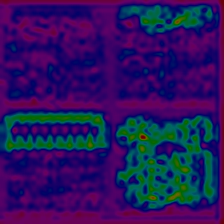

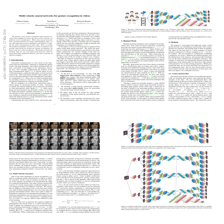

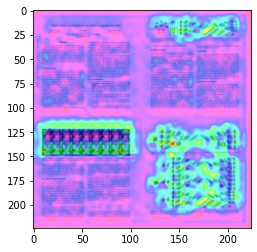

In [143]:
"Activation Heatmap: Bad Paper. ResNet"

from PIL import Image
from matplotlib.pyplot import imshow

# good_image = find_image(org_dataset, prep_dataset, model.cpu(), n_needed=10, need_label=0)
# bad_image = find_image(org_dataset, prep_dataset, model.cpu(), n_needed=10, need_label=0)
# grad_cam = GradCam(model, target_layer=11)
org_img, prep_img, target_class, loss = bad_image[1]
print("class:", target_class)
cam = grad_cam.generate_cam(prep_img, target_class)
heatmap, heatmap_on_image = apply_colormap_on_image(org_img, cam, 'hsv')
display(heatmap_on_image)
display(Image.fromarray((org_img*255.).astype(np.uint8)))
imshow(torch.tensor(org_img))
imshow(heatmap, alpha=0.5, cmap='jet')

class: 1


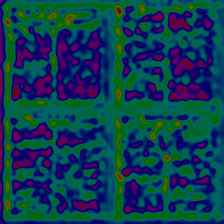

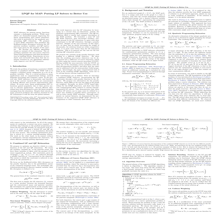

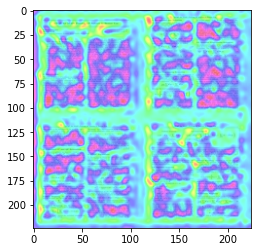

In [162]:
"Activation Heatmap: Good Paper. ResNet"

# found_image = find_image(org_dataset, prep_dataset, model.cpu(), n_needed=10, need_label=1)
# grad_cam = GradCam(model, target_layer=11)
org_img, prep_img, target_class, loss = good_image[0]
print("class:", target_class)
cam = grad_cam.generate_cam(prep_img, target_class)
heatmap, heatmap_on_image = apply_colormap_on_image(org_img, cam, 'hsv')
display(heatmap_on_image)
display(Image.fromarray((org_img*255.).astype(np.uint8)))
imshow(org_img)
imshow(heatmap, alpha=0.5, cmap='jet')

In [168]:
# model = resnet_tuned
model = vgg_tuned
found_image = find_image(org_dataset, prep_dataset, model.cpu(), n_needed=10)

In [100]:
org_dataset = PaperDataset('./data/arxiv.cs.lg_2007-2017/test')
dataset = PaperDataset('./data/arxiv.cs.lg_2007-2017/test', transform=preprocessing)
loader = torch.utils.data.DataLoader(
    train_set, batch_size=32, num_workers=n_worker,
    shuffle=False, pin_memory=True)
model = resnet_tuned
# model.fc = nn.Identity()
found_image = find_image(org_dataset, dataset, model.cpu(), n_needed=40, need_label=1)

orignal lenght 253
250 250
orignal lenght 253
250 250


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
len of accepted in all_loss: 40


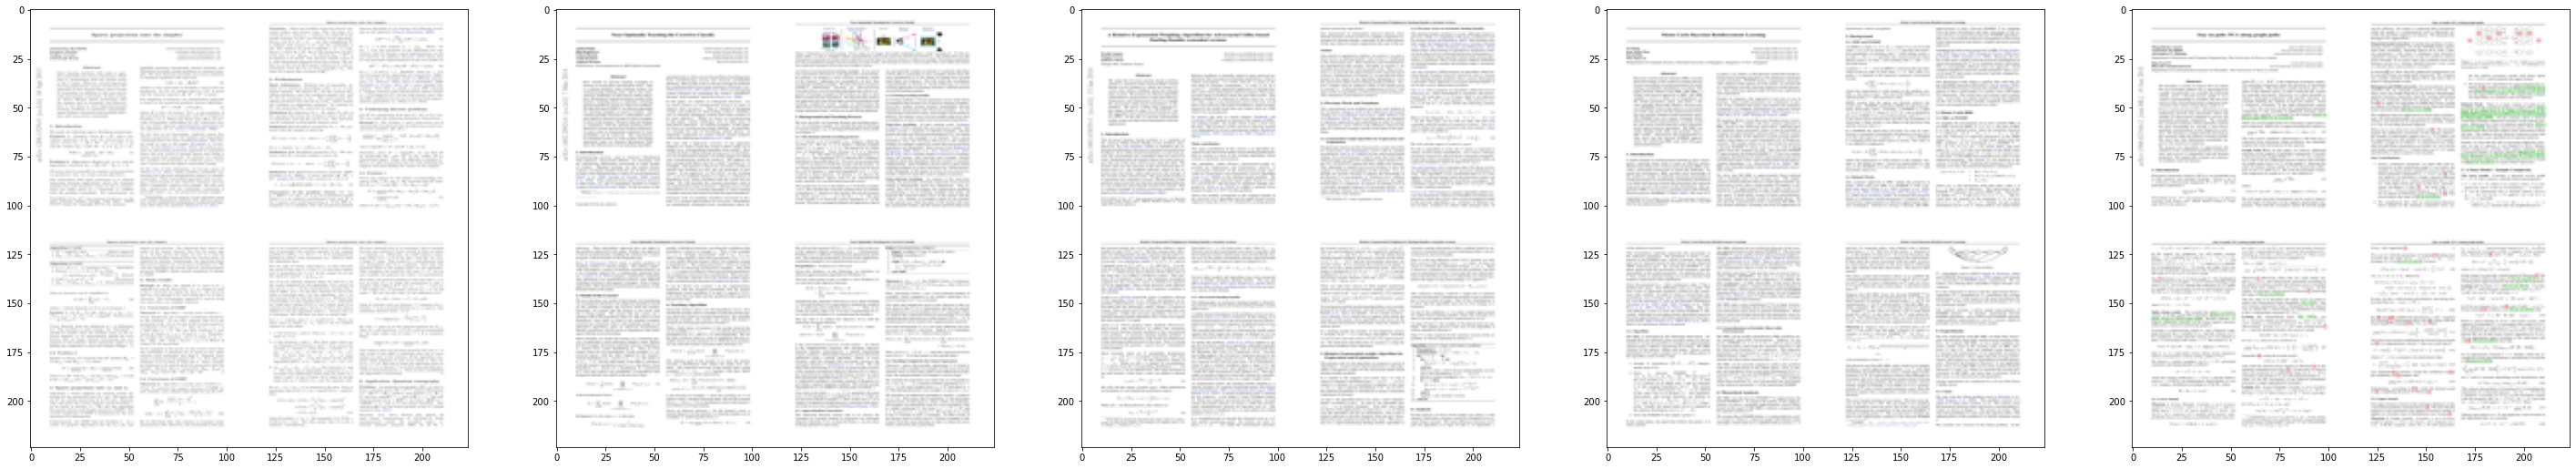

In [106]:
def display_np(img):
    display(Image.fromarray((img*255.).astype(np.uint8)))

# idxs = np.argsort(all_loss)

print([x[2] for x in found_image])
print("len of accepted in all_loss:", len(found_image))

each_needed = 5
fig = plt.figure(figsize=(50, 10))

for i, x in enumerate(found_image):
    if i >= each_needed:
        break
    org_img, _, y, _ = x
#     img_arr = org_dataset[idx][0]
#     img_arr = np.transpose(org_img.cpu().detach().numpy(), axes=(1, 2, 0))
#     print(img_arr.shape)
#     print(np.min(img_arr), np.max(img_arr))
    fig.add_subplot(1, each_needed, i + 1).imshow(org_img)
# fig.show()

In [220]:
dataset = PaperDataset('./data/arxiv.cs.lg_2007-2017/train', transform=preprocessing)
loader = torch.utils.data.DataLoader(
    train_set, batch_size=32, num_workers=n_worker,
    shuffle=False, pin_memory=True)
model = resnet_tuned
model.fc = nn.Identity()

all_feat = []

is_cuda = True
model.eval()
for (x, y) in loader:
    if is_cuda:
        x = x.cuda()
        y = y.cuda()

    n = x.shape[0]
    feat = model.cuda()(x)
    all_feat.append(feat)
all_feat = torch.vstack(all_feat)
all_feat = all_feat.cpu().detach().numpy()
print(all_feat.shape)

orignal lenght 4543
4483 4483
(4483, 512)


[1017059.375, 959628.8125, 923237.0, 899657.0, 879584.75, 866467.875, 855493.25, 846524.1875, 838764.25, 831501.25, 825056.875, 819718.625, 815551.4375, 809911.25, 805828.0625, 802363.125, 799394.8125, 796653.125, 793522.125, 790825.25, 788041.625, 785832.375, 784577.8125, 781139.0, 779587.25]


Text(0, 0.5, 'Inertia')

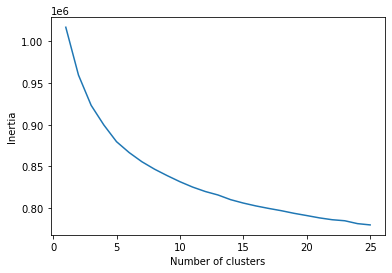

In [221]:
from sklearn.cluster import KMeans

K = range(1, 26)
all_distortion = []
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(all_feat)
    all_distortion.append(km.inertia_)

print(all_distortion)
plt.plot(K, all_distortion)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

In [242]:
from collections import Counter

k = 8
km = KMeans(n_clusters=k)
km.fit(all_feat)

df = dataset.df
df['cluster'] = km.labels_

top_each = 3

print(Counter(km.labels_))
df

Counter({0: 820, 2: 814, 5: 729, 4: 555, 3: 548, 1: 518, 6: 499})


paper_id  accepted  cluster
0     1505.01728     False        6
1      1402.6859     False        5
2      1412.8307     False        1
3     1611.09434      True        3
4     1611.01547     False        3
...          ...       ...      ...
4538  1501.07584     False        4
4539  1603.08023      True        0
4540  1612.01936      True        0
4541  1704.01155     False        0
4542  1705.05229     False        5

[4483 rows x 3 columns]

[176610.94  86918.67 122769.16 101440.58 143336.56 132902.02  91569.29]
[1 6 3 2 5 4 0]
orignal lenght 4543
4483 4483


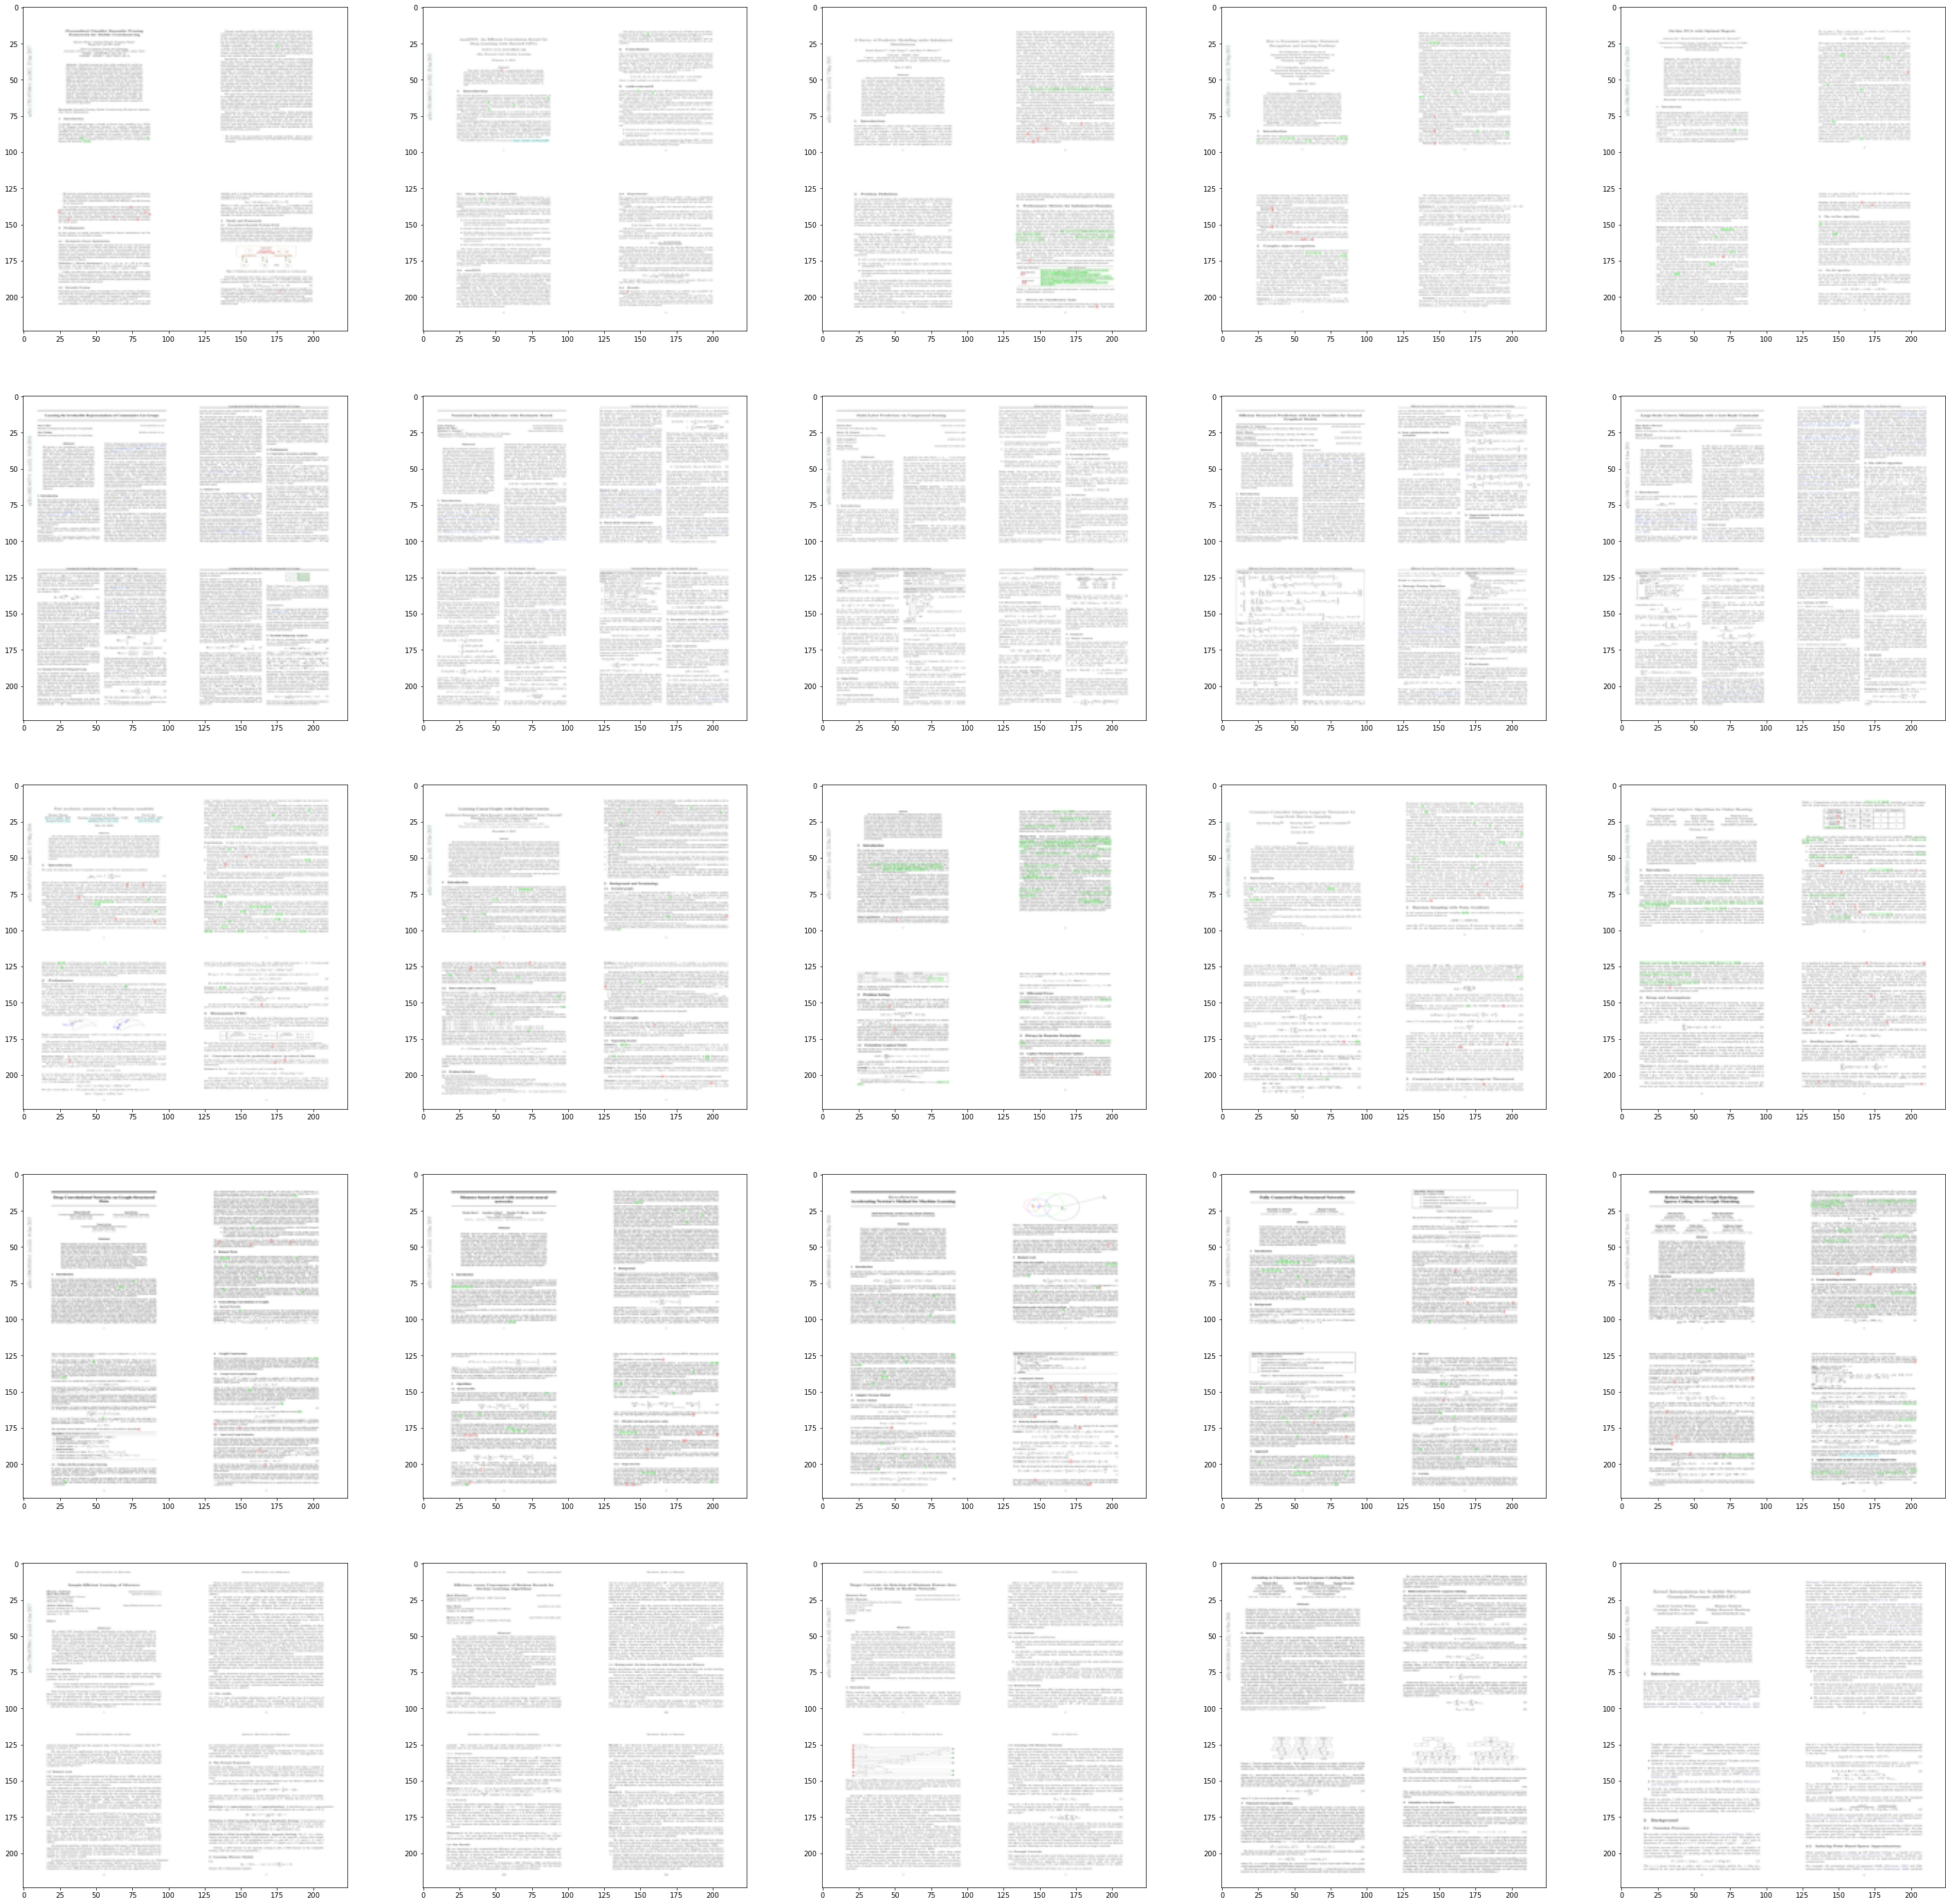

In [243]:
all_loss = np.sum((all_feat - km.cluster_centers_[km.labels_]) ** 2, axis=1)
idxs = np.argsort(all_loss)

showing_k = 5
assert showing_k <= k
cluster_loss = np.array([np.sum(all_loss[km.labels_ == i]) for i in range(k)])
print(cluster_loss)
print(np.argsort(cluster_loss))
least_loss_label = list(np.argsort(cluster_loss)[:showing_k])

org_dataset = PaperDataset('./data/arxiv.cs.lg_2007-2017/train')
labels = km.labels_
idxed_label = labels[idxs]

fig = plt.figure(figsize=(50, 50))
each_needed = 5

for i, cluster_idx in enumerate(least_loss_label):
    showing_idxs = idxs[idxed_label == cluster_idx][:each_needed]
    for j, idx in enumerate(showing_idxs):
        img_arr = org_dataset[idx][0]
        fig.add_subplot(showing_k, each_needed, i*each_needed+j+1).imshow(img_arr)